In [1]:
import pandas as pd
import pickle

In [2]:
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import seaborn as sns
from seaborn import plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV

%matplotlib inline

/home/farhaan/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Exploring the Raw DataFrame

In [3]:
student_data_df_raw = pickle.load(open('student_data_df.p',"rb"))

In [4]:
student_data_df_raw.head()

,Hispanic_White_Achievement_Gap,black_students,black_teachers,hispanic_students,hispanic_teachers,school_name,white_students,white_teachers
0,-14.0,26.3,4.1,19.9,4.6,A B SHEPARD HIGH SCH (CAMPUS) (9-12),50.6,90.5
1,-29.0,84.8,21.8,13.9,16.3,ACE TECHNICAL CHARTER HIGH SCHOOL (9-12),1.2,51.4
2,-4.0,2.9,1.6,61.1,4.5,ADDISON TRAIL HIGH SCHOOL (9-12),30.7,86.8
3,-30.0,1.5,0.9,7.6,0.4,ADLAI E STEVENSON HIGH SCHOOL (9-12),63.4,94.2
4,-5.0,42.5,21.8,42.2,16.3,AIR FORCE ACAD HIGH SCHOOL (9-12),11.0,51.4


In [5]:
student_data_df_raw.shape

(228, 8)

In [6]:
student_data_df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228 entries, 0 to 227
Data columns (total 8 columns):
Hispanic_White_Achievement_Gap    228 non-null float64
black_students                    228 non-null float64
black_teachers                    228 non-null float64
hispanic_students                 228 non-null float64
hispanic_teachers                 228 non-null float64
school_name                       228 non-null object
white_students                    228 non-null float64
white_teachers                    228 non-null float64
dtypes: float64(7), object(1)
memory usage: 14.3+ KB


# Cleaning the Data

While scraping, the program had stalled twice due to not allowing enough times for elements to load before searching for them. Due to this there were some duplicate rows in the dataframe.

In [7]:
student_data_df_raw.drop_duplicates(inplace=True)

In [8]:
student_data_df_raw.corr()

,Hispanic_White_Achievement_Gap,black_students,black_teachers,hispanic_students,hispanic_teachers,white_students,white_teachers
Hispanic_White_Achievement_Gap,1.000000,-0.166478,-0.168370,0.138470,-0.129539,0.033445,0.210227
black_students,-0.166478,1.000000,0.571722,-0.145378,0.226446,-0.613120,-0.380713
black_teachers,-0.168370,0.571722,1.000000,0.306391,0.710031,-0.680863,-0.840897
hispanic_students,0.138470,-0.145378,0.306391,1.000000,0.599360,-0.651379,-0.431511
hispanic_teachers,-0.129539,0.226446,0.710031,0.599360,1.000000,-0.670874,-0.773703
white_students,0.033445,-0.613120,-0.680863,-0.651379,-0.670874,1.000000,0.650665
white_teachers,0.210227,-0.380713,-0.840897,-0.431511,-0.773703,0.650665,1.000000


In [9]:
y,X1,X2,X3,X4,X5,X6 = list(student_data_df_raw.corr().columns)
(y,X1,X2,X3,X4,X5,X6)

('Hispanic_White_Achievement_Gap',
 'black_students',
 'black_teachers',
 'hispanic_students',
 'hispanic_teachers',
 'white_students',
 'white_teachers')

**Attention!**

Unfortunately, Illinois Report Card did not have data for teacher demographics by school, only by district. So, a large school district like chicago which have schools very diverse in teacher populations from each other will not contribute positively to our model.
Doing a quick check of sorting by the number of entries with identical teacher demographics, yields one row with a much larger count than others. 27 schools are represented by that combination of teacher demographics (21.8,16.3,51.4). The next highest count is 5.

Checking against the public records on the source website confirms that these are schools belonging to the Chicago Public Schools (CPS) system.
To maintain the validity of our data, we should remove all data associated with CPS schools.

In [10]:
print("Total number of schools:",len(student_data_df_raw))
check_large_districts_df = student_data_df_raw.groupby([X2,X4,X6],as_index=False)[y].count()
check_large_districts_df.sort_values([y],ascending=False).head()

Total number of schools: 225


,black_teachers,hispanic_teachers,white_teachers,Hispanic_White_Achievement_Gap
128,21.8,16.3,51.4,27
97,2.2,5.6,88.0,5
109,4.5,2.4,86.2,5
94,2.1,18.6,77.2,5
81,1.3,5.1,88.6,5


In [11]:
len(student_data_df_raw)

225

Below are the schools in the group of 27. A google search will confirm that all of these schools are indeed within CPS.

In [12]:
student_data_df_raw[(student_data_df_raw[X2]==21.8)&(student_data_df_raw[X4]==16.3)&(student_data_df_raw[X6]==51.4)]

,Hispanic_White_Achievement_Gap,black_students,black_teachers,hispanic_students,hispanic_teachers,school_name,white_students,white_teachers
1,-29.0,84.8,21.8,13.9,16.3,ACE TECHNICAL CHARTER HIGH SCHOOL (9-12),1.2,51.4
4,-5.0,42.5,21.8,42.2,16.3,AIR FORCE ACAD HIGH SCHOOL (9-12),11.0,51.4
7,-4.0,11.1,21.8,59.1,16.3,AMUNDSEN HIGH SCHOOL (9-12),12.3,51.4
25,-29.0,80.7,21.8,18.3,16.3,BOWEN HIGH SCHOOL (9-12),0.2,51.4
35,-8.0,41.3,21.8,18.7,16.3,CHICAGO HS FOR AGRICULT SCIENCES (9-12),36.7,51.4
36,-17.0,54.9,21.8,18.2,16.3,CHICAGO VIRTUAL CHARTER SCHOOL (K-12),16.0,51.4
47,-19.0,20.9,21.8,51.2,16.3,DISNEY II MAGNET HS (7-12),21.2,51.4
70,-29.0,57.7,21.8,39.9,16.3,GOODE STEM ACADEMY HS (9-12),1.0,51.4
91,-3.0,5.6,21.8,90.6,16.3,HUBBARD HIGH SCHOOL (9-12),2.8,51.4
94,-25.0,6.7,21.8,83.5,16.3,INTRINSIC CHARTER HIGH SCHOOL (7-12),6.4,51.4


Let's filter out CPS schools from the dataframe

In [13]:
schools_no_cps_df = student_data_df_raw[(student_data_df_raw[X2]!=21.8)&(student_data_df_raw[X4]!=16.3)&(student_data_df_raw[X6]!=51.4)]
print("Total number of schools in new filtered dataframe:",len(schools_no_cps_df))

Total number of schools in new filtered dataframe: 198


In [14]:
#Running the correlations between variables again:
schools_no_cps_df.corr()

,Hispanic_White_Achievement_Gap,black_students,black_teachers,hispanic_students,hispanic_teachers,white_students,white_teachers
Hispanic_White_Achievement_Gap,1.000000,0.035698,0.074169,0.175320,0.101418,-0.133717,0.032107
black_students,0.035698,1.000000,0.738804,-0.133475,-0.025081,-0.611993,-0.280299
black_teachers,0.074169,0.738804,1.000000,0.012861,0.130193,-0.546491,-0.459299
hispanic_students,0.175320,-0.133475,0.012861,1.000000,0.620390,-0.651670,-0.298466
hispanic_teachers,0.101418,-0.025081,0.130193,0.620390,1.000000,-0.508351,-0.364380
white_students,-0.133717,-0.611993,-0.546491,-0.651670,-0.508351,1.000000,0.470694
white_teachers,0.032107,-0.280299,-0.459299,-0.298466,-0.364380,0.470694,1.000000


Notice that the strongest positive correlations amongst the inputs are:

    - black_students/black_teacher(0.7388)
    - hispanic_students/hispanic_teachers(0.6204)
    - white_students/white_teachers (0.471)

This could possibly indicate:
- a preference of teachers to work with students of a similar ethnic background.
- a preference of administrators to hire teachers that share a common culture with the school's student population.
- a preference of white teachers to not work in schools with high concentrations of minority students (perhaps because these districts have lesser compensation packages compared to more affluent districts with a high concentration of white families)

**Doing a pairplot to visualize multicollinearity.**

Doesn't seem to be too great of of a multicollinearity between any of the inputs of interest. The only thing to note is that we accept the percentage of black teachers plus hispanic teachers should be negatively correlated with the percentage of white teachers since the total percentage of teachers cannot exceed 100%.

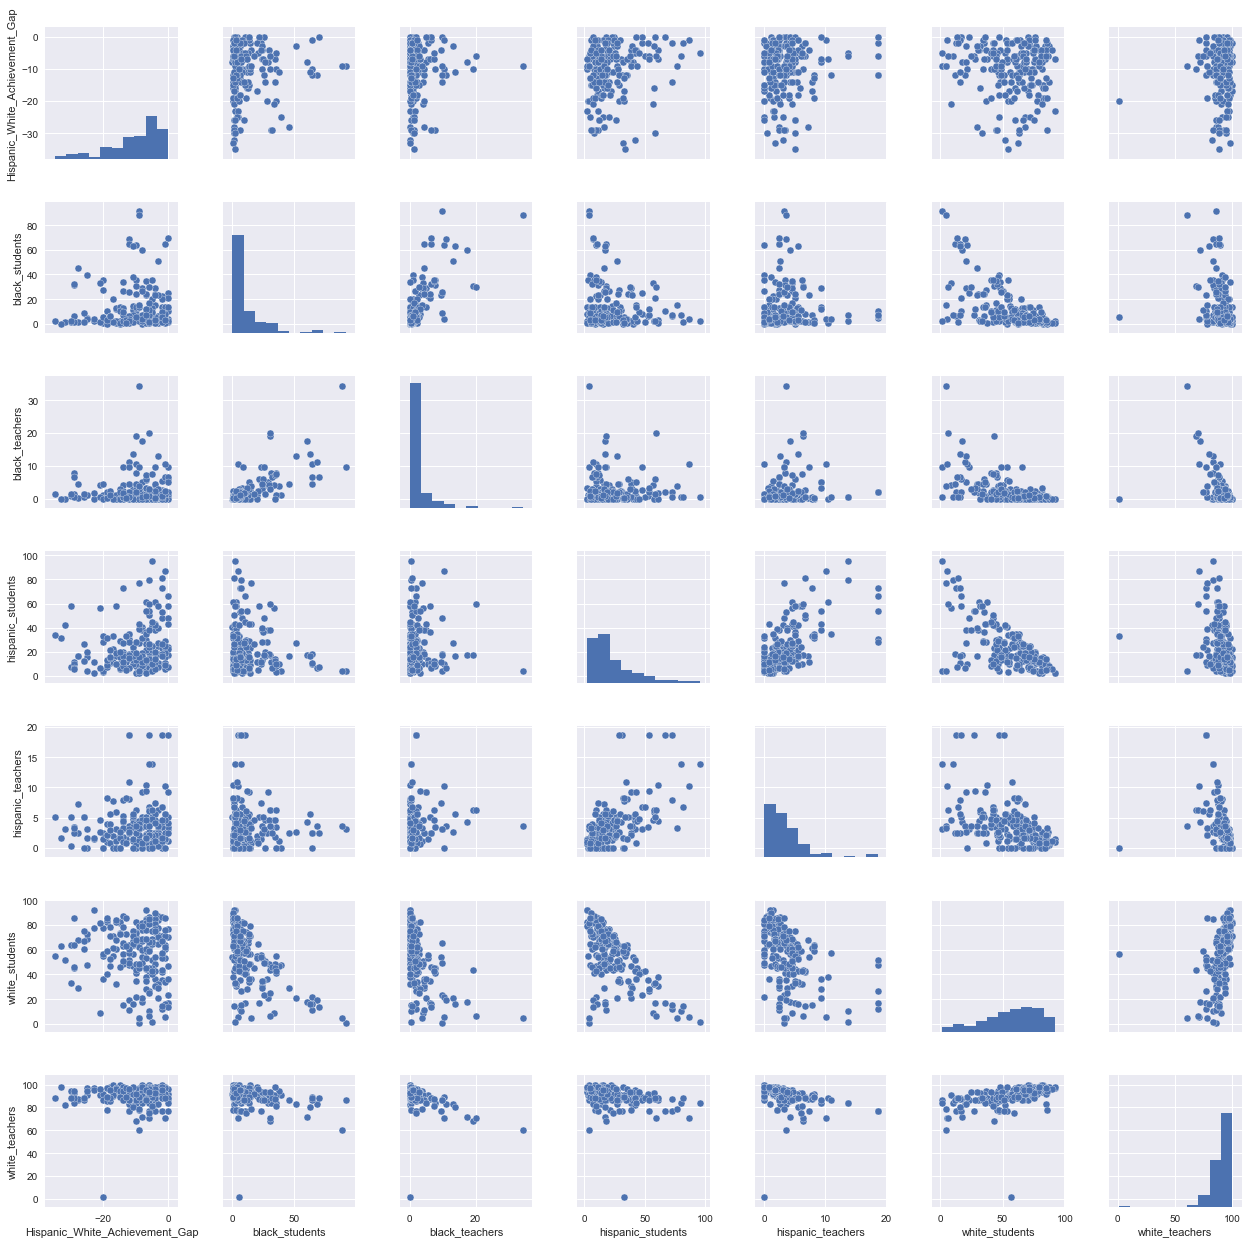

In [37]:
sns.pairplot(schools_no_cps_df)

In [15]:
schools_no_cps_df.columns

Index(['Hispanic_White_Achievement_Gap', 'black_students', 'black_teachers',
       'hispanic_students', 'hispanic_teachers', 'school_name',
       'white_students', 'white_teachers'],
      dtype='object')

In [16]:
# drop school_name column and rename the columns for ease of use
schools_no_name_df = schools_no_cps_df.loc[:,['Hispanic_White_Achievement_Gap', 'black_students', 'black_teachers',
       'hispanic_students', 'hispanic_teachers','white_students', 'white_teachers']]

"""
y : 'Hispanic_White_Achievement_Gap'
X1: 'black_students'
X2: 'black_teachers'
X3: 'hispanic_students'
X4: 'hispanic_teachers'
X5: 'white_students'
X6: 'white_teachers'
"""
schools_no_name_df.columns = ['y','X1','X2','X3','X4','X5','X6']
schools_no_name_df.head()

,y,X1,X2,X3,X4,X5,X6
0,-14.0,26.3,4.1,19.9,4.6,50.6,90.5
2,-4.0,2.9,1.6,61.1,4.5,30.7,86.8
3,-30.0,1.5,0.9,7.6,0.4,63.4,94.2
5,-3.0,1.8,0.0,24.8,2.8,71.7,94.4
6,-8.0,5.0,0.4,15.1,0.8,75.6,98.3


# Exploratory Data Analysis

Let's now run a Ordinary Least Square Linear Regression on the data using statsmodel

In [17]:
# Creating strings of variable names for input into patsy
y_string = list(schools_no_name_df.columns)[0]
X_string = list(schools_no_name_df.columns)[1:]
X_string = ' + '.join(X_string)

In [18]:
y, X = patsy.dmatrices(y_string+' ~ '+X_string, data=schools_no_name_df, return_type="dataframe")
#Performing an 'Ordinary Least Square Regression' on our data
model = sm.OLS(y, X)
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     2.011
Date:                Mon, 24 Jul 2017   Prob (F-statistic):             0.0661
Time:                        17:54:24   Log-Likelihood:                -683.29
No. Observations:                 198   AIC:                             1381.
Df Residuals:                     191   BIC:                             1404.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -32.7344     10.275     -3.186      0.002     -53.002     -12.467
X1             0.0830      0.103      0.808      0.420      -0.120       0.286
X2             0.2675      0.219      1.222      0.223      -0.164       0.699
X3             0.1643      0.087      1.886      0.061      -0.008       0.336
X4             0.0672      0.214      0.314      0.754      -0.355       0.490
X5             0.0837      0.094      0.892      0.374      -0.101       0.269
X6             0.1354      0.074      1.826      0.069      -0.011       0.282
==============================================================================
Omnibus:                       30.995   Durbin-Watson:                   2.057
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               40.205
Skew:                          -1.024   Prob(JB):                     1.86e-09
Kurtosis:                       3.822   Cond. No.                     2.05e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.05e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Both the R-Squared (0.059) and the Adjusted R-squared (0.030) are extremely weak. The t-scores seem to indicate that the only variables worth exploring further are X3 and X6.

However, a model with only **X3 (hispanic_students) and X6 (white_teachers)** as inputs yields an Adj R-squared (=0.029) that is even lower.

We do get a marginally better Adj R-squared (=0.041) when we include **X2 (black_teachers)** as a third input.

**Result to consider**

At this point it seems pretty clear that just having more hispanic teachers in a school doesn't automatically translate to a smaller difference in achievement gap. Thus, recommendations that minority students will do better when they have more minority teachers seem to not be supported by the data.

In [19]:
y, X = patsy.dmatrices(y_string+' ~ '+'X3 + X6', data=schools_no_name_df, return_type="dataframe")
#Performing an 'Ordinary Least Square Regression' on our data
model = sm.OLS(y, X)
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     3.911
Date:                Mon, 24 Jul 2017   Prob (F-statistic):             0.0216
Time:                        17:54:25   Log-Likelihood:                -685.46
No. Observations:                 198   AIC:                             1377.
Df Residuals:                     195   BIC:                             1387.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -19.3874      5.996     -3.233      0.001     -31.213      -7.562
X3             0.0880      0.032      2.759      0.006       0.025       0.151
X6             0.0799      0.063      1.260      0.209      -0.045       0.205
==============================================================================
Omnibus:                       33.582   Durbin-Watson:                   2.051
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               44.783
Skew:                          -1.084   Prob(JB):                     1.89e-10
Kurtosis:                       3.852   Cond. No.                     1.01e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.01e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [20]:
y, X = patsy.dmatrices(y_string+' ~ '+'X2 + X3 + X6', data=schools_no_name_df, return_type="dataframe")
#Performing an 'Ordinary Least Square Regression' on our data
model = sm.OLS(y, X)
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     3.795
Date:                Mon, 24 Jul 2017   Prob (F-statistic):             0.0112
Time:                        17:54:26   Log-Likelihood:                -683.71
No. Observations:                 198   AIC:                             1375.
Df Residuals:                     194   BIC:                             1389.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -25.9992      6.937     -3.748      0.000     -39.681     -12.318
X2             0.2849      0.153      1.861      0.064      -0.017       0.587
X3             0.0967      0.032      3.019      0.003       0.034       0.160
X6             0.1435      0.072      2.003      0.047       0.002       0.285
==============================================================================
Omnibus:                       32.786   Durbin-Watson:                   2.031
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               43.393
Skew:                          -1.062   Prob(JB):                     3.78e-10
Kurtosis:                       3.866   Cond. No.                     1.18e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.18e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**One thing to look at is to look at the total minority teacher population (rather than black and hispanic teachers individually) at a school.**
This can be done by taking 100 minus the white teacher population.

``
Percentage of minority teachers = 100 - Percentage of white teachers
             X7                 = 100 - X6
``

In [21]:
schools_no_name_df['X7'] = 100 - schools_no_name_df['X6']

In [22]:
schools_no_name_df.head()

,y,X1,X2,X3,X4,X5,X6,X7
0,-14.0,26.3,4.1,19.9,4.6,50.6,90.5,9.5
2,-4.0,2.9,1.6,61.1,4.5,30.7,86.8,13.2
3,-30.0,1.5,0.9,7.6,0.4,63.4,94.2,5.8
5,-3.0,1.8,0.0,24.8,2.8,71.7,94.4,5.6
6,-8.0,5.0,0.4,15.1,0.8,75.6,98.3,1.7


One of the big problems that became apparent with the pairplot on the raw data was that the distribution of each of the independent variables was not normally distributed.

In [24]:
y, X = patsy.dmatrices(y_string+' ~ '+'X4', data=schools_no_name_df, return_type="dataframe")
#Performing an 'Ordinary Least Square Regression' on our data
model = sm.OLS(y, X)
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     2.037
Date:                Tue, 25 Jul 2017   Prob (F-statistic):              0.155
Time:                        07:42:30   Log-Likelihood:                -688.33
No. Observations:                 198   AIC:                             1381.
Df Residuals:                     196   BIC:                             1387.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -11.0023      0.802    -13.721      0.000     -12.584      -9.421
X4             0.2271      0.159      1.427      0.155      -0.087       0.541
==============================================================================
Omnibus:                       29.105   Durbin-Watson:                   1.967
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               37.005
Skew:                          -1.026   Prob(JB):                     9.21e-09
Kurtosis:                       3.528   Cond. No.                         7.38
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

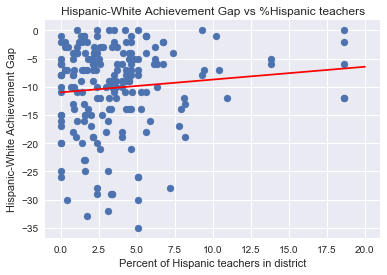

In [29]:
plt.scatter(schools_no_name_df['X4'],schools_no_name_df['y'])
x1_achievement_hisp_teachers_model = np.linspace(0,20,num=60)
y1_achievement_hisp_teachers_model = 0.227*x1_achievement_hisp_teachers_model - 11.002
plt.title('Hispanic-White Achievement Gap vs %Hispanic teachers')
plt.xlabel('Percent of Hispanic teachers in district')
plt.ylabel('Hispanic-White Achievement Gap')
plt.plot(x1_achievement_hisp_teachers_model,y1_achievement_hisp_teachers_model,'r-')
plt.savefig('achievement_gap_vs_hisp_teachers.png')

In [28]:
plt.show()